<a href="https://colab.research.google.com/github/yaramohamadi/dermo-segmentation/blob/128_segmentation/segment_128_block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
import os
import numpy as np
import random
import time
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.util import view_as_blocks
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from math import floor
random.seed(time.time())


def int64_feature(_value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[_value]))


def bytes_feature(_value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[_value]))


s_dir = '/content/drive/My Drive/skincancer/Dermoscopy/Dermoscopy/RGB'
gt_dir = '/content/drive/My Drive/skincancer/Dermoscopy/Dermoscopy/GT'
patch_size = (256 + 32, 320 + 32)
step_size = (256 - 32, 320 - 32)
middle_point = (256, 320)
files = os.listdir(s_dir)

stat = {
    '0': 0,
    '1:20': 0,
    '20:40': 0,
    '40:60': 0,
    '60:80': 0,
    '80:100': 0
}

input('wanna overwrite?')

writer = tf.python_io.TFRecordWriter('/content/drive/My Drive/skincancer/train_128_block.tfrecords')

for ind, file in enumerate(files):
  # 9/10 of files are for training
  if ind % 10 > 0:

    print(ind)

    # S is RGB, gt is 8 bit 2 level(0, 255) gray
    s = imageio.imread(os.path.join(s_dir, file))

    # normalize
    mean = np.mean(s)
    std = np.std(s)
    s = (s - mean) / std
    ###########

    gt = imageio.imread(os.path.join(gt_dir, file)).astype(np.bool).astype(np.uint8)


    # width and height offset to cut out to be able to divide image into correct patch sizes
    #h_o = (len(s) % patch_size[0]) / 2
    #w_o = (len(s[0]) % patch_size[1]) / 2
    #x_s, y_s = floor(w_o), floor(h_o)
    #h_new, w_new = int(len(s)/patch_size[0])*patch_size[0], int(len(s[0])/patch_size[1])*patch_size[1]
    #s = s[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new, :]
    #gt = gt[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new]
    #
    #image = np.dstack((s, gt))
    #image_patches = view_as_blocks(image, (patch_size[0], patch_size[1], 4)).reshape(-1, patch_size[0], patch_size[1], 4)



    # width and height offset to cut out to be able to divide image into correct patch sizes
    #h_o = (len(s) % middle_point[0]) / 2
    #w_o = (len(s[0]) % middle_point[1]) / 2
    #x_s, y_s = floor(w_o), floor(h_o)
    #h_new, w_new = int(len(s)/middle_point[0])*middle_point[0], int(len(s[0])/middle_point[1])*middle_point[1]
    #s = s[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new, :]
    #gt = gt[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new]

    image = np.dstack((gt, s))

    image_patches = extract_patches_2d(image, patch_size, 20)



    
    #image_patches = []

    #image_patches.append(image[:patch_size[0], :patch_size[1], :])
    #image_patches.append(image[:patch_size[0], step_size[1]:, :])
    #image_patches.append(image[step_size[0]:, :patch_size[1], :])
    #image_patches.append(image[step_size[0]:, step_size[1]:, :])

    for instance in image_patches:
        img_patch = instance[:, :, :-1]
        gt_patch = instance[:, :, -1]

        #if not (float(np.count_nonzero(img_patch[:, :, -1]) / (patch_size[0] * patch_size[1])) >= 0.95):
        #    print('what the hell')
        #    wtf_var = plt.imshow(img_patch)
        #    plt.show()
        #    input("Yo wtf?")
        #    continue

        #ratio = np.count_nonzero(gt_patch) / (patch_size[0] * patch_size[1])
        #print(ratio)
        flag = 1

        #if ratio == 0:
        #    if random.random() < 0.3945: #0.5856:
        #        stat['0'] += 1
        #        flag = 1
        #elif ratio < 0.2:
        #    if random.random() < 0.5037: #0.6033:
        #        stat['1:20'] += 1
        #        flag = 1
        #elif ratio < 0.4:
        #    if random.random() < 0.8048: #0.9460: # 0.017718620/1000
        #        stat['20:40'] += 1
        #        flag = 1
        #elif ratio < 0.6:
        #    if random.random() < 0.943: #0.016172048/1000:
        #        stat['40:60'] += 1
        #        flag = 1
        #elif ratio < 0.8:
        #    if random.random() < 0.8261: #left for 1080 dataset this is for 3400 dataset 0.9725:
        #        stat['60:80'] += 1
        #        flag = 1
        #else:
        #    if random.random() < 0.1664: #0.2370:
        #        stat['80:100'] += 1
        #        flag = 1

        if flag:
            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        'image': bytes_feature(img_patch.astype(np.float32).tostring()),
                        'label': bytes_feature(gt_patch.astype(np.int32).tostring())
                    }
                ))

            writer.write(example.SerializeToString())

writer.close()
print("Created dataset successfully")

#for key, value in stat.items():
#    print(key, ' ----> ', value)

# old with patch_2d_extract

# 1:20  ---->  117094
# 60:80  ---->  123899
# 80:100  ---->  102003
# 20:40  ---->  127767
# 0  ---->  145805
# 40:60  ---->  133018

# new with view_as_block

# 0  --->  49624: 0.604308487
# 1:20  --->  2713: 0.033038225
# 20:40  --->  1455: 0.017718620
# 40:60  --->  1328: 0.016172048
# 60:80  --->  1482: 0.018047420
# 80:100  --->  25515: 0.310715200
# 82117

# 0  ---->  1947
# 1:20  ---->  1796
# 20:40  ---->  1455
# 40:60  ---->  1328
# 60:80  ---->  1482
# 80:100  ---->  1779

wanna overwrite?
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
71
72
73
74
75
76
77
78
79
81
82
83
84
85
86
87
88
89
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
125
126
127
128
129
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
161
162
163
164
165
166
167
168
169
171
172
173
174
175
176
177
178
179
181
182
183
184
185
186
187
188
189
191
192
193
194
195
196
197
198
199
Created dataset successfully


(?, 136, 168, 64)
(?, 68, 84, 128)
(?, 34, 42, 256)
(?, 17, 21, 512)
(?, 9, 11, 512)
(?, 9, 11, 2)
(?, 34, 42, 2)
(?, 34, 42, 2)
(?, 34, 42, 2)
(?, 272, 336, 2)
Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.
Starting Epoch   1
Best Dice    0.0
Current Dice 0
00:00:27
00:00:55
00:01:23
00:01:50
00:02:18
pred2: 0.49326632584719016
pred3: 0.49326632584719016
pred4: 0.463052136481544


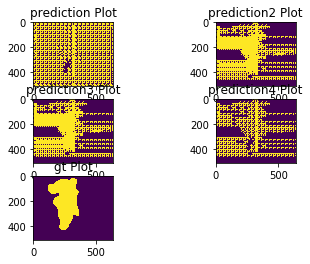

Epoch: 5, Current Dice: 0.4760, Best Dice: 0.0000

00:02:51
00:03:19
00:03:47
00:04:14
00:04:42
pred2: 0.34525221955890034
pred3: 0.34525221955890034
pred4: 0.3359429258168481


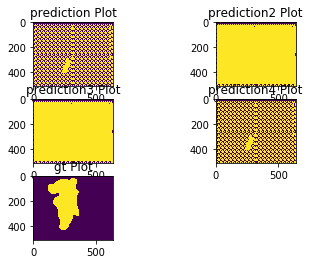

Epoch: 10, Current Dice: 0.4681, Best Dice: 0.4760

00:05:13
00:05:41
00:06:09
00:06:37
00:07:05
pred2: 0.6313595002037213
pred3: 0.6313595002037213
pred4: 0.5886972075054653


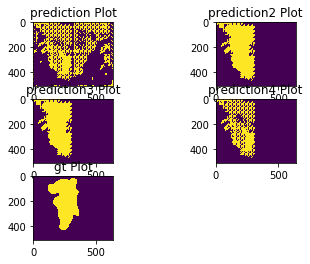

Epoch: 15, Current Dice: 0.5593, Best Dice: 0.4760

00:07:38
00:08:05
00:08:33
00:09:01
00:09:29
pred2: 0.45974566883778634
pred3: 0.45974566883778634
pred4: 0.4579067797869337


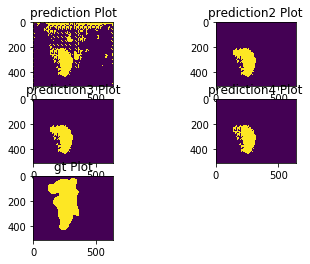

Epoch: 20, Current Dice: 0.6845, Best Dice: 0.5593

00:10:02
00:10:30
00:10:58
00:11:26
00:11:53
pred2: 0.4425732477994114
pred3: 0.4425732477994114
pred4: 0.43271426277233005


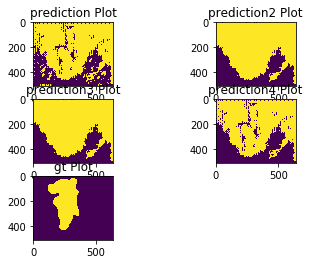

Epoch: 25, Current Dice: 0.6242, Best Dice: 0.6845

00:12:25
00:12:53
00:13:21
00:13:49
00:14:16
pred2: 0.8624335792652624
pred3: 0.8624335792652624
pred4: 0.8509660278071556


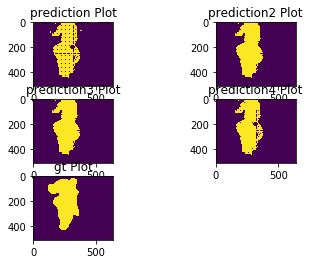

Epoch: 30, Current Dice: 0.7536, Best Dice: 0.6845

00:14:49
00:15:17
00:15:45
00:16:12
00:16:40
pred2: 0.6963647783928081
pred3: 0.6963647783928081
pred4: 0.6929012396328035


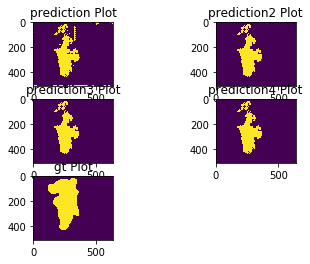

Epoch: 35, Current Dice: 0.6828, Best Dice: 0.7536

00:17:11
00:17:39
00:18:07
00:18:34
00:19:02
pred2: 0.0055942336360981755
pred3: 0.0055942336360981755
pred4: 0.005400088122880183


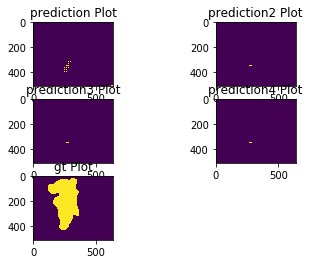

Epoch: 40, Current Dice: 0.0581, Best Dice: 0.7536

00:19:33
00:20:01
00:20:29
00:20:56
00:21:24
pred2: 0.8297503678743393
pred3: 0.8297503678743393
pred4: 0.8277613572891455


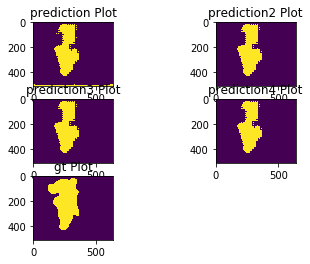

Epoch: 45, Current Dice: 0.7656, Best Dice: 0.7536

00:21:57
00:22:25
00:22:53
00:23:20
00:23:48
pred2: 0.33057114399472187
pred3: 0.33057114399472187
pred4: 0.33057423166604116


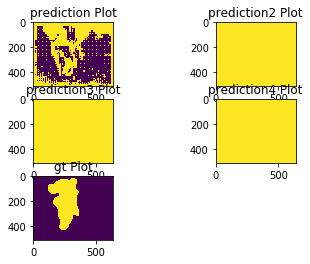

Epoch: 50, Current Dice: 0.5433, Best Dice: 0.7656

00:24:20
00:24:48
00:25:15
00:25:43
00:26:11
pred2: 0.31245825841253533
pred3: 0.31245825841253533
pred4: 0.31090636383115494


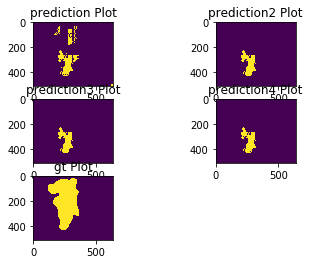

Epoch: 55, Current Dice: 0.5719, Best Dice: 0.7656

00:26:42
00:27:10
00:27:38
00:28:06
00:28:33
pred2: 0.8811952325941788
pred3: 0.8811952325941788
pred4: 0.8803523102135634


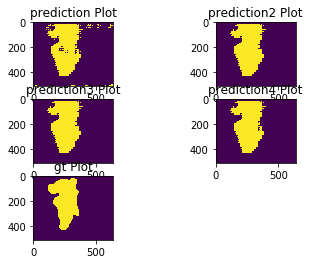

Epoch: 60, Current Dice: 0.7985, Best Dice: 0.7656

00:29:06
00:29:34
00:30:02
00:30:29
00:30:57
pred2: 0.5182964764436401
pred3: 0.5182964764436401
pred4: 0.5178661013688606


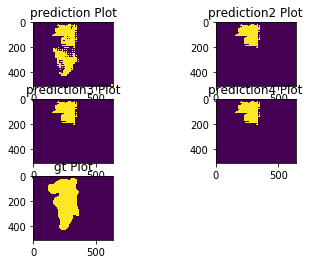

Epoch: 65, Current Dice: 0.7282, Best Dice: 0.7985

00:31:28
00:31:56
00:32:24
00:32:51
00:33:19
pred2: 0.8381118590542674
pred3: 0.8381118590542674
pred4: 0.8359643521474778


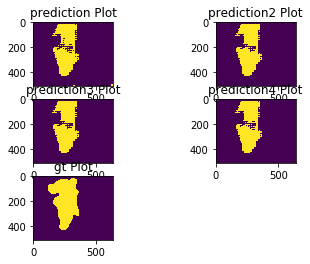

Epoch: 70, Current Dice: 0.7852, Best Dice: 0.7985

00:33:50
00:34:18
00:34:46
00:35:13
00:35:41
pred2: 0.5306419589675712
pred3: 0.5306419589675712
pred4: 0.5304837458026693


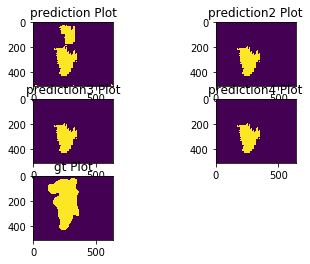

Epoch: 75, Current Dice: 0.7420, Best Dice: 0.7985

00:36:12
00:36:40
00:37:08
00:37:35
00:38:03
pred2: 0.8707264809566599
pred3: 0.8707264809566599
pred4: 0.8707766397456134


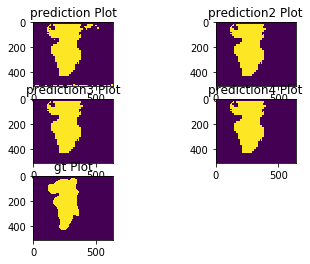

Epoch: 80, Current Dice: 0.7977, Best Dice: 0.7985

00:38:34
00:39:02
00:39:30
00:39:57
00:40:25
pred2: 0.7292020526363172
pred3: 0.7292020526363172
pred4: 0.7300648030368285


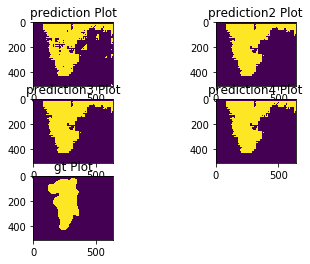

Epoch: 85, Current Dice: 0.6541, Best Dice: 0.7985

00:40:56
00:41:24
00:41:52
00:42:20
00:42:47
pred2: 0.7137662566971799
pred3: 0.7137662566971799
pred4: 0.7139369610849773


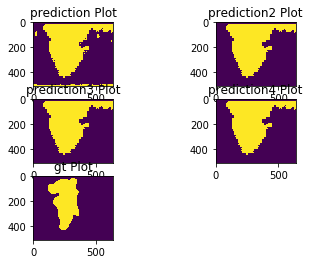

Epoch: 90, Current Dice: 0.7604, Best Dice: 0.7985

00:43:18
00:43:46
00:44:14
00:44:41
00:45:09
pred2: 0.467931245480336
pred3: 0.467931245480336
pred4: 0.46834747618729444


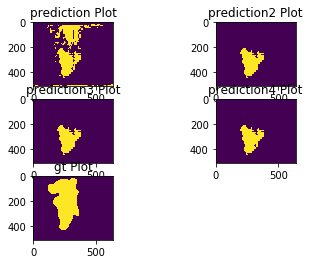

Epoch: 95, Current Dice: 0.7652, Best Dice: 0.7985

00:45:40
00:46:08
00:46:36
00:47:03
00:47:31
pred2: 0.7684142788937248
pred3: 0.7684142788937248
pred4: 0.7689093284943184


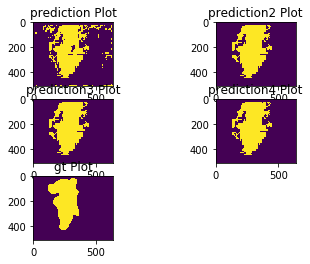

Epoch: 100, Current Dice: 0.7831, Best Dice: 0.7985

00:48:02
00:48:30
00:48:58
00:49:25
00:49:53
pred2: 0.4269562701894798
pred3: 0.4269562701894798
pred4: 0.42642229858724706


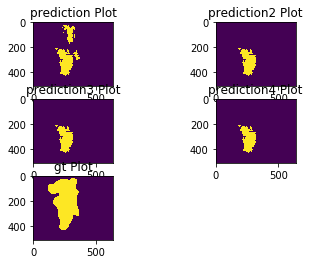

Epoch: 105, Current Dice: 0.6931, Best Dice: 0.7985

00:50:24
00:50:52
00:51:20
00:51:47
00:52:15
pred2: 0.831878011707254
pred3: 0.831878011707254
pred4: 0.8144748911115139


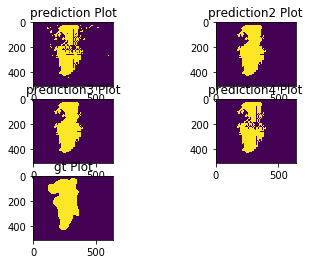

Epoch: 110, Current Dice: 0.7769, Best Dice: 0.7985

00:52:46
00:53:14
00:53:42
00:54:10
00:54:37
pred2: 0.029159389475282863
pred3: 0.029159389475282863
pred4: 0.029159389475282863


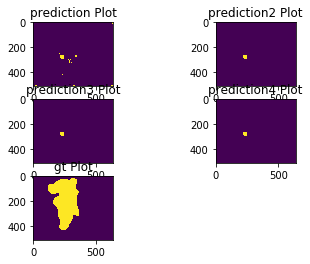

Epoch: 115, Current Dice: 0.2107, Best Dice: 0.7985

00:55:08
00:55:36
00:56:04
00:56:31
00:56:59
pred2: 0.4341107661202975
pred3: 0.4341107661202975
pred4: 0.4339795230606284


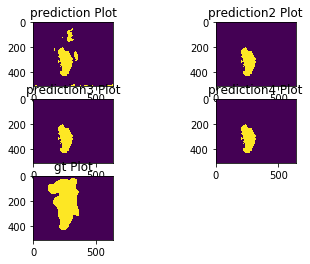

Epoch: 120, Current Dice: 0.6777, Best Dice: 0.7985

00:57:30
00:57:58
00:58:26
00:58:53
00:59:21
pred2: 0.4804833892598102
pred3: 0.4804833892598102
pred4: 0.4804976126586755


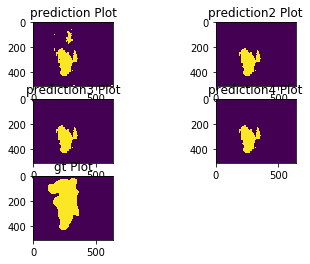

Epoch: 125, Current Dice: 0.6621, Best Dice: 0.7985

00:59:52
01:00:20
01:00:48
01:01:15
01:01:43
pred2: 0.47431397574984047
pred3: 0.47431397574984047
pred4: 0.47383221609132503


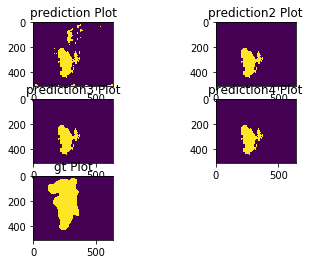

Epoch: 130, Current Dice: 0.7046, Best Dice: 0.7985

01:02:15
01:02:42
01:03:10
01:03:38
01:04:06
pred2: 0.8040916519449242
pred3: 0.8040916519449242
pred4: 0.804762209675888


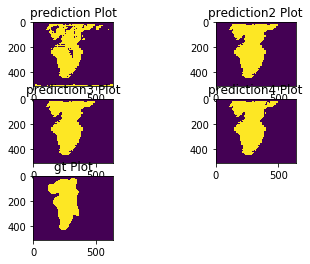

Epoch: 135, Current Dice: 0.7822, Best Dice: 0.7985

01:04:37
01:05:04
01:05:32
01:06:00
01:06:28
pred2: 0.4773050376017307
pred3: 0.4773050376017307
pred4: 0.4773397841818477


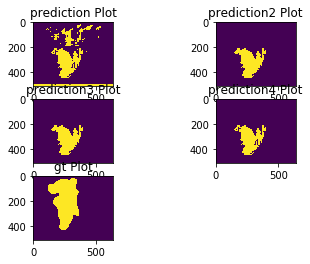

Epoch: 140, Current Dice: 0.7256, Best Dice: 0.7985

01:06:59
01:07:27
01:07:54
01:08:22
01:08:50
pred2: 0.4360609711613923
pred3: 0.4360609711613923
pred4: 0.4360979276596999


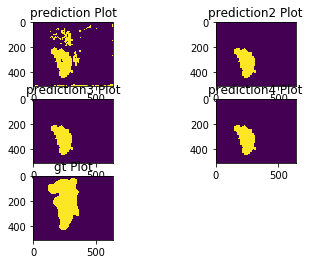

Epoch: 145, Current Dice: 0.6675, Best Dice: 0.7985

01:09:21
01:09:49
01:10:17
01:10:45
01:11:12
pred2: 0.22398220727440396
pred3: 0.22398220727440396
pred4: 0.22394415862711237


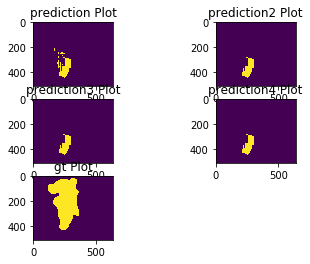

Epoch: 150, Current Dice: 0.1954, Best Dice: 0.7985

01:11:44
01:12:11
01:12:39
01:13:07
01:13:35
pred2: 0.4661424177013428
pred3: 0.4661424177013428
pred4: 0.46629968698792107


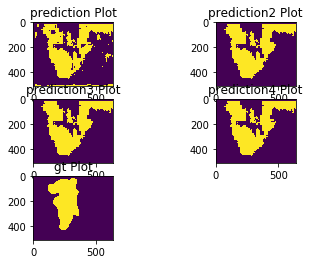

Epoch: 155, Current Dice: 0.6487, Best Dice: 0.7985

01:14:06
01:14:34
01:15:01
01:15:29
01:15:57
pred2: 0.3995242306871207
pred3: 0.3995242306871207
pred4: 0.3996501789781972


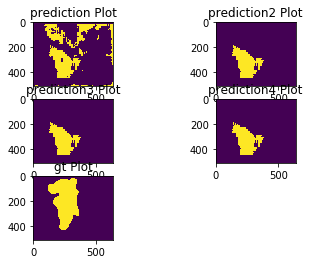

Epoch: 160, Current Dice: 0.5198, Best Dice: 0.7985

01:16:28
01:16:56
01:17:24
01:17:51
01:18:19
pred2: 0.45282379717355636
pred3: 0.45282379717355636
pred4: 0.45260590745296236


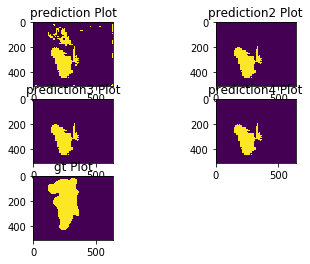

Epoch: 165, Current Dice: 0.5334, Best Dice: 0.7985

01:18:50
01:19:18
01:19:46
01:20:14
01:20:42
pred2: 0.4912270188130043
pred3: 0.4912270188130043
pred4: 0.4916156283602103


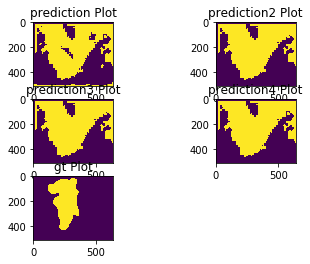

Epoch: 170, Current Dice: 0.6006, Best Dice: 0.7985

01:21:13
01:21:41
01:22:08
01:22:36
01:23:04
pred2: 0.21230549023617218
pred3: 0.21230549023617218
pred4: 0.21219462648963103


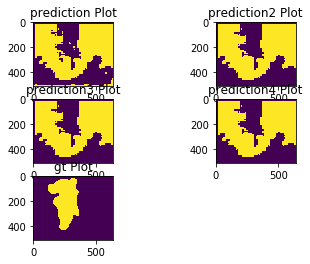

Epoch: 175, Current Dice: 0.3577, Best Dice: 0.7985

01:23:36
01:24:03
01:24:31
01:24:59
01:25:26
pred2: 0.47834444822334277
pred3: 0.47834444822334277
pred4: 0.478418729156345


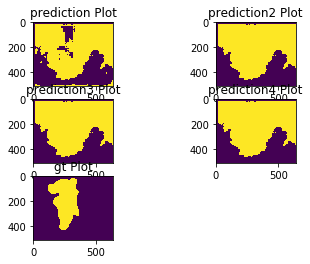

Epoch: 180, Current Dice: 0.5275, Best Dice: 0.7985

01:25:58
01:26:25
01:26:53
01:27:21
01:27:49
pred2: 0.0019707770712405117
pred3: 0.0019707770712405117
pred4: 0.0019707770712405117


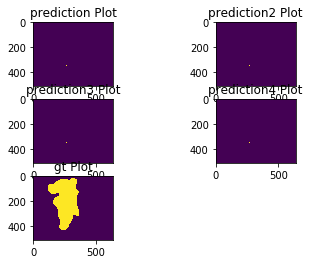

Epoch: 185, Current Dice: 0.1996, Best Dice: 0.7985

01:28:20
01:28:48
01:29:15
01:29:43
01:30:11
pred2: 0.6956805474716475
pred3: 0.6956805474716475
pred4: 0.6815054032032639


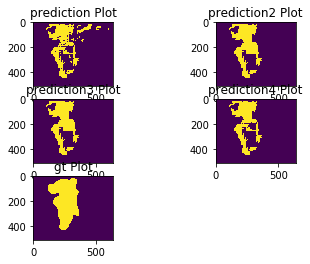

Epoch: 190, Current Dice: 0.7023, Best Dice: 0.7985

01:30:42
01:31:10
01:31:38
01:32:06
01:32:34
pred2: 0.613389928247984
pred3: 0.613389928247984
pred4: 0.6138319124480275


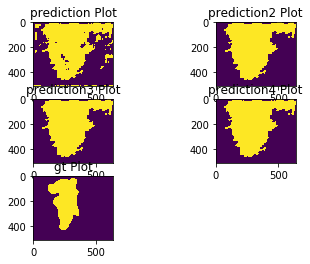

Epoch: 195, Current Dice: 0.7242, Best Dice: 0.7985

01:33:05
01:33:33
01:34:01
01:34:29
01:34:57
pred2: 0.6869846127688515
pred3: 0.6869846127688515
pred4: 0.6870040525987644


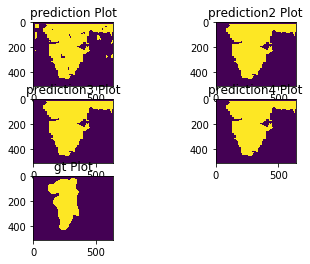

Epoch: 200, Current Dice: 0.7464, Best Dice: 0.7985

01:35:28
01:35:56
01:36:24
01:36:52
01:37:19
pred2: 0.5841321584712986
pred3: 0.5841321584712986
pred4: 0.5841795036901283


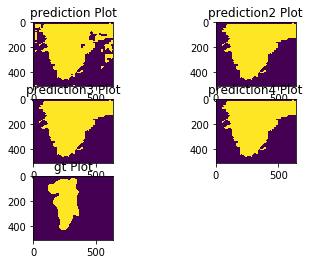

Epoch: 205, Current Dice: 0.7411, Best Dice: 0.7985

01:37:51
01:38:19
01:38:47
01:39:15
01:39:42
pred2: 0.580600408148652
pred3: 0.580600408148652
pred4: 0.585925221151009


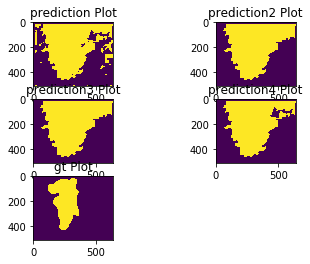

Epoch: 210, Current Dice: 0.7301, Best Dice: 0.7985

01:40:14
01:40:42
01:41:10
01:41:37
01:42:05
pred2: 0.5607354644629242
pred3: 0.5607354644629242
pred4: 0.5608243441472546


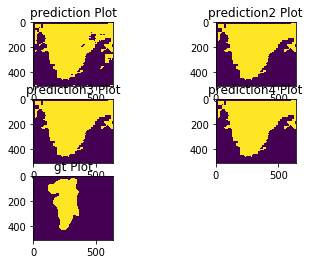

Epoch: 215, Current Dice: 0.7266, Best Dice: 0.7985



KeyboardInterrupt: ignored

In [16]:
import tensorflow as tf
import numpy as np
import os
import imageio
from skimage.util import view_as_blocks, view_as_windows
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import time
from math import floor
import re
from math import ceil


train_file = '/content/drive/My Drive/skincancer/train_128_block.tfrecords'

result_images_file = '/content/drive/My Drive/skincancer/128_block_lr_16pad_dice/results/%d'
result_images_folder = '/content/drive/My Drive/skincancer/128_block_lr_16pad_dice/results'
gt_dir = '/content/drive/My Drive/skincancer/Dermoscopy/Dermoscopy/GT/'
s_dir = '/content/drive/My Drive/skincancer/Dermoscopy/Dermoscopy/RGB/'
stat_file = '/content/drive/My Drive/skincancer/128_block_lr_16pad_dice/results.txt'

save_path = '/content/drive/My Drive/skincancer/128_block_lr_16pad_dice/checkpoints/best_validation'
load_dir = '/content/drive/My Drive/skincancer/128_block_lr_16pad_dice/checkpoints/'
save_path_test = '/content/drive/My Drive/skincancer/128_block_lr_16pad_dice/checkpoints_test/best_validation'
load_dir_test = '/content/drive/My Drive/skincancer/128_block_lr_16pad_dice/checkpoints_test/'

pad_amount = 16
patch_size = (256 + pad_amount, 320 + pad_amount)
step_size = (256 - pad_amount, 320 - pad_amount)
middle_point = (256, 320)
lr = 0.0001
skip_connection_out_size = (int(ceil(patch_size[0]/8)), int(ceil(patch_size[1]/8)))

tf.reset_default_graph()

sess = tf.Session()

def parse_function(example_proto):
    features = {
        'label': tf.FixedLenFeature((), tf.string, default_value=""),
        'image': tf.FixedLenFeature((), tf.string, default_value="")
    }
    parsed_features = tf.parse_single_example(example_proto, features)

    lbl = tf.reshape(tf.decode_raw(parsed_features['label'], tf.int32), shape=[patch_size[0], patch_size[1]])
    img = tf.reshape(tf.decode_raw(parsed_features['image'], tf.float32), shape=[patch_size[0], patch_size[1], 3])

    return img, lbl


def read_data():
    training_data_set = tf.data.TFRecordDataset(train_file)
    training_data_set = training_data_set.shuffle(buffer_size=1000, seed=int(time.time()))
    training_data_set = training_data_set.map(parse_function)
    training_data_set.repeat()
    training_data_set = training_data_set.batch(batch_size=20)
    training_data_set = training_data_set.prefetch(tf.data.experimental.AUTOTUNE)

    test_data_set = tf.data.Dataset.from_tensor_slices((input_patches, input_labels))
    #test_data_set = tf.data.TFRecordDataset('../test_image.tfrecords')
    #test_data_set = test_data_set.map(parse_function)
    test_data_set = test_data_set.batch(batch_size=100)
    #training_data_set.repeat()
    #test_data_set = test_data_set.prefetch(tf.data.experimental.AUTOTUNE)

    iterator = tf.data.Iterator.from_structure(output_types=training_data_set.output_types,
                                               output_shapes=training_data_set.output_shapes)

    training_init_op = iterator.make_initializer(training_data_set)
    test_init_op = iterator.make_initializer(test_data_set)

    next_element = iterator.get_next()

    return training_init_op, test_init_op, next_element


def train(c):
    sess.run(train_init)
    while True:
        try:
            sess.run(train_step, feed_dict={is_training: True})

        except tf.errors.OutOfRangeError:
            break
    print(time.strftime('%H:%M:%S', time.gmtime(time.time() - c)))



def evaluate(epoch):
    if not os.path.exists(os.path.join(result_images_file % epoch)):
        os.mkdir(os.path.join(result_images_file % epoch))
    stat_dict = {  # keeps track of the evaluation results
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }

    y_label = []
    y_scores = []
    for ind, image_file in enumerate(image_files):

      # 1/10 of images are for testing 
      if ind % 10 == 0:

        s = imageio.imread(os.path.join(s_dir, image_file))
        gt = imageio.imread(os.path.join(gt_dir, image_file)).astype(np.bool).astype(np.uint8)

        h_o = (len(s) % middle_point[0]) / 2
        w_o = (len(s[0]) % middle_point[1]) / 2
        x_s, y_s = floor(w_o), floor(h_o)
        h_new, w_new = int(len(s)/middle_point[0])*middle_point[0], int(len(s[0])/middle_point[1])*middle_point[1]
        s = s[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new, :]
        gt = gt[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new]

        # create patches
        #image_patches = view_as_blocks(s, (patch_size[0], patch_size[1], 3)).reshape(-1, patch_size[0], patch_size[1], 3)
        #image_patches = view_as_windows(s, (patch_size[0], patch_size[1], 3), step=step_size).reshape(-1, patch_size[0], patch_size[1], 3)
        image_patches = []
        image_patches.append(s[:patch_size[0], :patch_size[1], :])
        image_patches.append(s[:patch_size[0], step_size[1]:, :])
        image_patches.append(s[step_size[0]:, :patch_size[1], :])
        image_patches.append(s[step_size[0]:, step_size[1]:, :])

        #gt_patches = view_as_blocks(gt, patch_size).reshape(-1, patch_size[0], patch_size[1])
        #gt_patches = view_as_windows(gt, (patch_size), step=step_size).reshape(-1, patch_size[0], patch_size[1])
        gt_patches = []
        gt_patches.append(gt[:patch_size[0], :patch_size[1]])
        gt_patches.append(gt[:patch_size[0], step_size[1]:])
        gt_patches.append(gt[step_size[0]:, :patch_size[1]])
        gt_patches.append(gt[step_size[0]:, step_size[1]:])

        sess.run(test_init, feed_dict={input_patches: image_patches, input_labels: gt_patches})

        gt_patches = view_as_blocks(gt, middle_point).reshape(-1, middle_point[0], middle_point[1])
        ##########

        fcn_output = []
        while True:
            try:
                fcn_output.append(sess.run(output, feed_dict={is_training: False}))
            except tf.errors.OutOfRangeError:
                break

        #num_col = gt.shape[1] // patch_size[1]
        #num_row = gt.shape[0] // patch_size[0]
        #
        ##turn patch lists into images
        #fcn_output = np.concatenate(fcn_output, axis=0) 
        #
        #scores = fcn_output[:, :, :, 1]
        #scores = scores.reshape(-1, patch_size[0], patch_size[1])
        #predictions = np.argmax(fcn_output, axis=-1)
        #
        #scores = scores.reshape(num_row, num_col , patch_size[0], patch_size[1])
        #predictions = predictions.reshape(num_row, num_col , patch_size[0], patch_size[1])
        #predictions = predictions.swapaxes(2, 1)
        #prediction = predictions.reshape(num_row*patch_size[0], num_col*patch_size[1])
        #scores = scores.swapaxes(2, 1)
        #score = scores.reshape(num_row*patch_size[0], num_col*patch_size[1])
        #
        #print(prediction.shape)

        #___________________________________________________________________________________________
        #___Holding into account stepsize and overlappings (cropping is done, no average taken)____#

        fcn_output2 = []

        fcn_output = np.concatenate(fcn_output, axis=0) 

        gt2 = []
        #print(len(fcn_output), len(fcn_output[0]),len(fcn_output[0][0]),len(fcn_output[0][0][0]))

        for i, fcn in enumerate(fcn_output):
          if i ==0:
            fcn_output2.append(fcn[:middle_point[0], :middle_point[1]])
          elif i ==1:
            fcn_output2.append(fcn[:middle_point[0], pad_amount:])
          elif i ==2:
            fcn_output2.append(fcn[pad_amount:, :middle_point[1]])
          elif i ==3:
            fcn_output2.append(fcn[pad_amount:, pad_amount:])

        fcn_output2 = np.array(fcn_output2)

        num_col = gt.shape[1] // middle_point[1]
        num_row = gt.shape[0] // middle_point[0]
        
        scores = fcn_output2[:, :, :, 1]
        scores = scores.reshape(-1, middle_point[0], middle_point[1])
        predictions = np.argmax(fcn_output2, axis=-1)
        
        scores = scores.reshape(num_row, num_col, middle_point[0], middle_point[1])
        predictions = predictions.reshape(num_row, num_col, middle_point[0], middle_point[1])
        predictions = predictions.swapaxes(2, 1)
        prediction = predictions.reshape(num_row*middle_point[0], num_col*middle_point[1])
        scores = scores.swapaxes(2, 1)
        score = scores.reshape(num_row*middle_point[0], num_col*middle_point[1])

        #___________________________________________________________________________________________
        ind += 1

        if ind == 1:
          # First largest connected component then hole filling
          # Get largest connected component
          from scipy import ndimage
          # hole filling
          prediction2 = ndimage.morphology.binary_fill_holes(prediction).astype(int)
          from skimage.measure import label
          labelss = label(prediction2)
          # if any connected component keep that
          if labelss.max() != 0:
              prediction2 = labelss == np.argmax(np.bincount(labelss.flat)[1:]) + 1

          stat_dict['tp'] += np.sum(np.logical_and(prediction2 == 1, gt == 1))
          stat_dict['tn'] += np.sum(np.logical_and(prediction2 == 0, gt == 0))
          stat_dict['fp'] += np.sum(np.logical_and(prediction2 == 1, gt == 0))
          stat_dict['fn'] += np.sum(np.logical_and(prediction2 == 0, gt == 1))

          print("pred2: " + str(float(2 * stat_dict['tp']) / ((2 * stat_dict['tp']) + (stat_dict['fp'] + stat_dict['fn']))))


          # then largest connected component first hole filling
          from skimage.measure import label
          labelss = label(prediction)
          # if any connected component keep that
          prediction3 = prediction
          if labelss.max() != 0:
              prediction3 = labelss == np.argmax(np.bincount(labelss.flat)[1:]) + 1
          # Get largest connected component
          from scipy import ndimage
          # hole filling
          prediction3 = ndimage.morphology.binary_fill_holes(prediction3).astype(int)

          stat_dict['tp'] += np.sum(np.logical_and(prediction3 == 1, gt == 1))
          stat_dict['tn'] += np.sum(np.logical_and(prediction3 == 0, gt == 0))
          stat_dict['fp'] += np.sum(np.logical_and(prediction3 == 1, gt == 0))
          stat_dict['fn'] += np.sum(np.logical_and(prediction3 == 0, gt == 1))

          print("pred3: " + str(float(2 * stat_dict['tp']) / ((2 * stat_dict['tp']) + (stat_dict['fp'] + stat_dict['fn']))))


          # then largest connected component first hole filling
          from skimage.measure import label
          labelss = label(prediction)
          # if any connected component keep that
          prediction4 = prediction
          if labelss.max() != 0:
              prediction4 = labelss == np.argmax(np.bincount(labelss.flat)[1:]) + 1
          # Get largest connected component
          from scipy import ndimage
          # hole filling
          prediction4 = ndimage.morphology.binary_fill_holes(prediction4, structure=np.ones((5, 5))).astype(
              int)
          
          stat_dict['tp'] += np.sum(np.logical_and(prediction4 == 1, gt == 1))
          stat_dict['tn'] += np.sum(np.logical_and(prediction4 == 0, gt == 0))
          stat_dict['fp'] += np.sum(np.logical_and(prediction4 == 1, gt == 0))
          stat_dict['fn'] += np.sum(np.logical_and(prediction4 == 0, gt == 1))

          print("pred4: " + str(float(2 * stat_dict['tp']) / ((2 * stat_dict['tp']) + (stat_dict['fp'] + stat_dict['fn']))))



          a1 = plt.subplot(3, 2, 1)
          plt.imshow(prediction)
          a2 = plt.subplot(3, 2, 2)
          plt.imshow(prediction2)
          a3 = plt.subplot(3, 2, 3)
          plt.imshow(prediction3)
          a4 = plt.subplot(3, 2, 4)
          plt.imshow(prediction4)
          a5 = plt.subplot(3, 2, 5)
          plt.imshow(gt)
          a1.title.set_text('prediction Plot')
          a2.title.set_text('prediction2 Plot')
          a3.title.set_text('prediction3 Plot')
          a4.title.set_text('prediction4 Plot')
          a5.title.set_text('gt Plot')
          plt.show()
          #input()


        generated_map = np.hstack((prediction.astype(np.uint8), gt)) * 255
        imageio.imwrite(os.path.join(result_images_folder, str(epoch), str(str(ind) + '.bmp')),
                        generated_map)

        stat_dict['tp'] += np.sum(np.logical_and(prediction == 1, gt == 1))
        stat_dict['tn'] += np.sum(np.logical_and(prediction == 0, gt == 0))
        stat_dict['fp'] += np.sum(np.logical_and(prediction == 1, gt == 0))
        stat_dict['fn'] += np.sum(np.logical_and(prediction == 0, gt == 1))

        #y_label.append(lbls[ind].flatten())
        # y_scores.append(score.flatten())

    accuracy_ = (stat_dict['tp'] + stat_dict['tn']) / (
                stat_dict['fp'] + stat_dict['fn'] + stat_dict['tp'] + stat_dict['tn'])
    sensitivity_ = stat_dict['tp'] / (stat_dict['tp'] + stat_dict['fn'])
    specificity_ = stat_dict['tn'] / (stat_dict['fp'] + stat_dict['tn'])
    dice_ = float(2 * stat_dict['tp']) / ((2 * stat_dict['tp']) + (stat_dict['fp'] + stat_dict['fn']))
    # dice2_ = float(2 * stat_dict2['tp']) / ((2 * stat_dict2['tp']) + (stat_dict2['fp'] + stat_dict2['fn']))

    # print(dice_, dice2_)
    #input()

    global stat_file
    file = open(stat_file, 'a')
    # Auc_Roc: %0.4lf {roc_auc_}
    file.write('tp: %d, tn: %d, fp: %d, fn: %d\naccuracy: %lf\n\nsensitivity: %lf\nspecificity: %lf\ndice: %lf\n' %
               (stat_dict['tp'], stat_dict['tn'], stat_dict['fp'], stat_dict['fn'], accuracy_, sensitivity_,
                specificity_, dice_))
    file.close()
    return dice_


image_files = os.listdir(s_dir)

input_patches = tf.placeholder(dtype=tf.float32, shape=[None, patch_size[0], patch_size[1], 3], name='patches')
input_labels = tf.placeholder(dtype=tf.int32, shape=[None, patch_size[0], patch_size[1]], name='labels')
is_training = tf.placeholder(dtype=tf.bool, shape=[], name='is_training')

# last_pred = tf.placeholder(dtype=tf.int32, shape=[None, patch_size[0], patch_size[1]], name='last_pred')

variables = dict()

variables['wconv1'] = tf.get_variable(name='wconv1', shape=[3, 3, 3, 64])
variables['bconv1'] = tf.get_variable(name='bconv1', shape=[64])
variables['wconv2'] = tf.get_variable(name='wconv2', shape=[3, 3, 64, 64])
variables['bconv2'] = tf.get_variable(name='bconv2', shape=[64])

variables['wconv3'] = tf.get_variable(name='wconv3', shape=[3, 3, 64, 128])
variables['bconv3'] = tf.get_variable(name='bconv3', shape=[128])
variables['wconv4'] = tf.get_variable(name='wconv4', shape=[3, 3, 128, 128])
variables['bconv4'] = tf.get_variable(name='bconv4', shape=[128])

variables['wconv5'] = tf.get_variable(name='wconv5', shape=[3, 3, 128, 256])
variables['bconv5'] = tf.get_variable(name='bconv5', shape=[256])
variables['wconv6'] = tf.get_variable(name='wconv6', shape=[3, 3, 256, 256])
variables['bconv6'] = tf.get_variable(name='bconv6', shape=[256])

variables['wconv7'] = tf.get_variable(name='wconv7', shape=[3, 3, 256, 512])
variables['bconv7'] = tf.get_variable(name='bconv7', shape=[512])
variables['wconv8'] = tf.get_variable(name='wconv8', shape=[3, 3, 512, 512])
variables['bconv8'] = tf.get_variable(name='bconv8', shape=[512])

variables['wconv9'] = tf.get_variable(name='wconv9', shape=[3, 3, 512, 512])
variables['bconv9'] = tf.get_variable(name='bconv9', shape=[512])
variables['wconv10'] = tf.get_variable(name='wconv10', shape=[3, 3, 512, 512])
variables['bconv10'] = tf.get_variable(name='bconv10', shape=[512])

variables['wfcn1'] = tf.get_variable(name='wfcn1', shape=[3, 3, 512, 4096])
variables['bfcn1'] = tf.get_variable(name='bfcn1', shape=[4096])

variables['wfcn2'] = tf.get_variable(name='wfcn2', shape=[1, 1, 4096, 2])
variables['bfcn2'] = tf.get_variable(name='bfcn2', shape=[2])

variables['wfcn3'] = tf.get_variable(name='wfcn3', shape=[1, 1, 512, 2])
variables['bfcn3'] = tf.get_variable(name='bfcn3', shape=[2])

variables['wfcn4'] = tf.get_variable(name='wfcn4', shape=[1, 1, 256, 2])
variables['bfcn4'] = tf.get_variable(name='bfcn4', shape=[2])

variables['wdeconv3'] = tf.get_variable(name='wdeconv3', shape=[4, 4, 2, 2])

variables['wdeconv2'] = tf.get_variable(name='wdeconv2', shape=[2, 2, 2, 2])

variables['wdeconv1'] = tf.get_variable(name='wdeconv1', shape=[8, 8, 2, 2])

#variables['wconv_classifier'] = tf.get_variable(name='wconv_classifier', shape=[1, 1, 64, 2])
#variables['bconv_classifier'] = tf.get_variable(name='bconv_classifier', shape=[2])

train_init, test_init, next_element = read_data()
image, labele = next_element



#ENCODER
f1 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(image, variables['wconv1'], [1, 1, 1, 1], padding='SAME', ), variables['bconv1']))
f1 = tf.layers.batch_normalization(f1, trainable=True, training=is_training)
f1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f1, variables['wconv2'], [1, 1, 1, 1], padding='SAME'), variables['bconv2']))
f1 = tf.layers.batch_normalization(f1, trainable=True, training=is_training)
f1 = tf.nn.max_pool(f1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(f1.shape)

f2 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(f1, variables['wconv3'], [1, 1, 1, 1], padding='SAME', ), variables['bconv3']))
f2 = tf.layers.batch_normalization(f2, trainable=True, training=is_training)
f2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f2, variables['wconv4'], [1, 1, 1, 1], padding='SAME'), variables['bconv4']))
f2 = tf.layers.batch_normalization(f2, trainable=True, training=is_training)
f2 = tf.nn.max_pool(f2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(f2.shape)

pool3 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(f2, variables['wconv5'], [1, 1, 1, 1], padding='SAME', ), variables['bconv5']))
pool3 = tf.layers.batch_normalization(pool3, trainable=True, training=is_training)
pool3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wconv6'], [1, 1, 1, 1], padding='SAME'), variables['bconv6']))
pool3 = tf.nn.max_pool(pool3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool3.shape)


pool4 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wconv7'], [1, 1, 1, 1], padding='SAME', ), variables['bconv7']))
pool4 = tf.layers.batch_normalization(pool4, trainable=True, training=is_training)
pool4 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wconv8'], [1, 1, 1, 1], padding='SAME'), variables['bconv8']))
pool4 = tf.layers.batch_normalization(pool4, trainable=True, training=is_training)
pool4 = tf.nn.max_pool(pool4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool4.shape)

pool5 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wconv9'], [1, 1, 1, 1], padding='SAME', ), variables['bconv9']))
pool5 = tf.layers.batch_normalization(pool5, trainable=True, training=is_training)
pool5 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool5, variables['wconv10'], [1, 1, 1, 1], padding='SAME'), variables['bconv10']))
pool5 = tf.layers.batch_normalization(pool5, trainable=True, training=is_training)
pool5 = tf.nn.max_pool(pool5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool5.shape)

conv7 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool5, variables['wfcn1'], [1, 1, 1, 1], padding='SAME', ), variables['bfcn1']))
conv7 = tf.layers.batch_normalization(conv7, trainable=True, training=is_training)
conv7 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv7, variables['wfcn2'], [1, 1, 1, 1], padding='SAME'), variables['bfcn2']))
conv7 = tf.layers.batch_normalization(conv7, trainable=True, training=is_training)

print(conv7.shape)

#DECODER
input_shape = tf.shape(conv7)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 2])
convt1 = tf.nn.conv2d_transpose(conv7, variables['wdeconv3'], output_shape, strides=[1, 4, 4, 1], padding='SAME')

print(convt1.shape)

input_shape = tf.shape(pool4)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 2])
convt2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wfcn3'], [1, 1, 1, 1], padding='SAME'), variables['bfcn3']))
convt2 = tf.nn.conv2d_transpose(convt2, variables['wdeconv2'], output_shape, strides=[1, 2, 2, 1], padding='SAME')

print(convt2.shape)

convt3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wfcn4'], [1, 1, 1, 1], padding='SAME'), variables['bfcn4']))

print(convt3.shape)

h = tf.math.add_n([convt1, convt2, convt3])

input_shape = tf.shape(h)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, patch_size[0], patch_size[1], 2])
h = tf.nn.conv2d_transpose(h, variables['wdeconv1'], output_shape, strides=[1, 8, 8, 1], padding='SAME')

print(h.shape)

output = tf.nn.softmax(h)


#LOSS____________________________________________________________

#def dice_loss(onehots_true, probabilities):
#  numerator = tf.reduce_sum(onehots_true * probabilities, axis=0)
#  denominator = tf.reduce_sum(onehots_true + probabilities, axis=0)
#  loss = 1 - (2 * numerator + 1) / (denominator + 1)
#  return loss

#loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=last_pred))
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labele, logits=h))

#dice_out = tf.math.subtract(output[:,:,:,1], output[:,:,:,0]) / 2 + 0.5
#labele = tf.cast(labele, tf.float32)
#h = tf.cast(h, tf.float32)
#output = tf.cast(tf.argmax(output, axis=-1), tf.int32)
#loss = dice_loss(labele, dice_out)

#______________________________________________________________

batchnorm1 = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
train_step = tf.train.AdamOptimizer(lr).minimize(loss)



train_step = tf.group([train_step, batchnorm1])
sess.run(tf.global_variables_initializer())

# Checkpoint restoration and transfer learning
saver = tf.train.Saver()

starting_epoch = 1
val_acc = 0
last_improvement = 1
best_dice = 0.0
require_improvement = 1000
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=load_dir)

    # Try and load the data in the checkpoint.
    saver.restore(sess, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")

sess.run(tf.global_variables_initializer())

# append to the accuracy file
temp = True
if temp:
    if os.stat(stat_file).st_size != 0:
        with open(stat_file, 'r') as acc_file:
            lineList = acc_file.readlines()
            float_list = []
            int_list = []
            ind = -1
            while not float_list:
                float_list = re.findall(r'\d+\.\d+', lineList[ind])
                int_list = re.findall(r'\d+', lineList[ind])
                ind -= 1
            starting_epoch = int(int_list[0]) + 1
            best_dice = float(float_list[1])
            val_acc = float(float_list[0])

# training loop
print("Starting Epoch   " + str(starting_epoch))
print("Best Dice    " + str(best_dice))
print("Current Dice " + str(val_acc))

epochs = 1000

start_time = time.time()

for epoch in range(starting_epoch, epochs):
    train(start_time)
    if not epoch % 5:
        saver.save(sess=sess, save_path=save_path)
        temp_dice = evaluate(epoch)
        print('Epoch: %d, Current Dice: %.4lf, Best Dice: %.4lf\n' % (epoch, temp_dice, best_dice))

        if temp_dice > best_dice:
            saver.save(sess=sess, save_path=save_path_test)
            best_dice = temp_dice
            last_improvement = epoch

        with open(stat_file, 'a') as file:
            file.write('Epoch: %d, Current Dice: %.4lf, Best Dice: %.4lf\n' % (epoch, temp_dice, best_dice))

        if epoch - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization process...")
            break



In [0]:
tf.__version__

'1.15.0'